# Deep Learning 2023 - Coursework
## Classifying Plankton!

The aim of this coursework will be for you to design a deep learning architecture to predict identify plankton species from images. 

***Your aim is to design a model that, when given a new image of a plankton speciment would return to which species it belongs to.***

You are free to use any architecture you prefer, from what we have seen in class. You can decide to use unsupervised pre-training of only supervised end-to-end training - the approach you choose is your choice. 

### Hand-in date: Thursday 16th of March before 4:30pm (on Moodle)

### Steps & Hints
* First, look at the data. What are the different classes? How different are they? What type of transformations for your data augmentation do you think would be acceptable here?. 
* You will note that it is *very* imbalanced (large differences in number of samples between classes) --- this will be one challenge to look for. 
* Also, note that the dataset is rather small (hint: you will need to think about data augmentation!). 
* Second, try and load the data and separate into training, validation and test set (or better, use cross-validation)
* Write a DataLoader class for the data (Hint: you will want to put the data augmentation in the data loader). 
* Think about pre-processing of the input? The output? Normalisation or not? Data augmentation? Which one? 
* Design a network for the task. What layers? How many? Do you want to use an Autoencoder for unsupervised pre-training? 
* Choose a loss function for your network
* Select optimiser and training parameters (batch size, learning rate)
* Optimise your model, and tune hyperparameters (especially learning rate, momentum etc)
* Analyse the results on the test data. How to measure success? Which classes are recognised well, which are not? Is there confusion between some classes? Look at failure cases. 
* If time allows, go back to drawing board and try a more complex, or better, model. 
* Explain your thought process, justify your choices and discuss the results!

### Submission
* submit TWO files on Moodle: 
  * **your notebook**: use `File -> download .ipynb` to download the notebook file locally from colab. 
  * **a PDF file** of your notebook's output as you see it: use `File -> print` to generate a PDF. 
* your notebook must clearly contains separate cells for: 
  * setting up your model and data loader
  * training your model from data
  * loading your pretrained model (eg, from github/gitlab)
  * testing your model on test data. 
* The training cells must be disabled by a flag, such that when running *run all* on your notebook it does
  * load the data
  * load your model 
  * apply the model to the test data
  * analyse and display the results and accuracy 
* In addition provide markup cell:
  * containing your student number at the top
  * to describe and motivate your design choices: architecture, pre-processing, training regime
  * to analyse, describe and comment on your results
  * to provide some discussion on what you think are the limitations of your solution and what could be future work

* **Note that you must put your trained model on a github so that your code can download it.**


### Assessment criteria 
* In order to get a pass mark, you will need to demonstrate that you have designed and trained a deep NN to solve the problem, using sensible approach and reasonable efforts to tune hyper-parameters. You have analysed the results. It is NOT necessary to have any level of accuracy (a network that predicts poorly will always yield a pass mark if it is designed, tuned and analysed sensibly). 
* In order to get a good mark, you will show good understanding of the approach and provide a working solution. 
* in order to get a high mark, you will demonstrate a working approach of gradual improvement between different versions of your solution. 
* bonus marks for attempting something original if well motivated - even if it does not yield increased performance. 
* bonus marks for getting high performance, and some more points are to grab for getting the best performance in the class. 

### Notes
* make sure to clearly set aside training, validation and test sets to ensure proper setting of all hyperparameters. 
* I recommend to start with small models that can be easier to train to set a baseline performance before attempting more complex one. 
* Be mindful of the time!

### Data 
The following cells will show you how to download the data and view it. 

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import collections

# Loading the data
# we will use wget to get the archive
# !wget --no-check-certificate "https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1" -O plankton.pt

c:\Users\Anirbit\anaconda3\envs\DLearn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The classes in this dataset are: 
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

And the numbers of examples per class are: 
2.0     257
8.0     235
7.0     219
10.0    157
11.0    135
0.0     134
3.0     110
6.0      92
9.0      76
4.0      70
5.0      67
1.0      65
dtype: int64


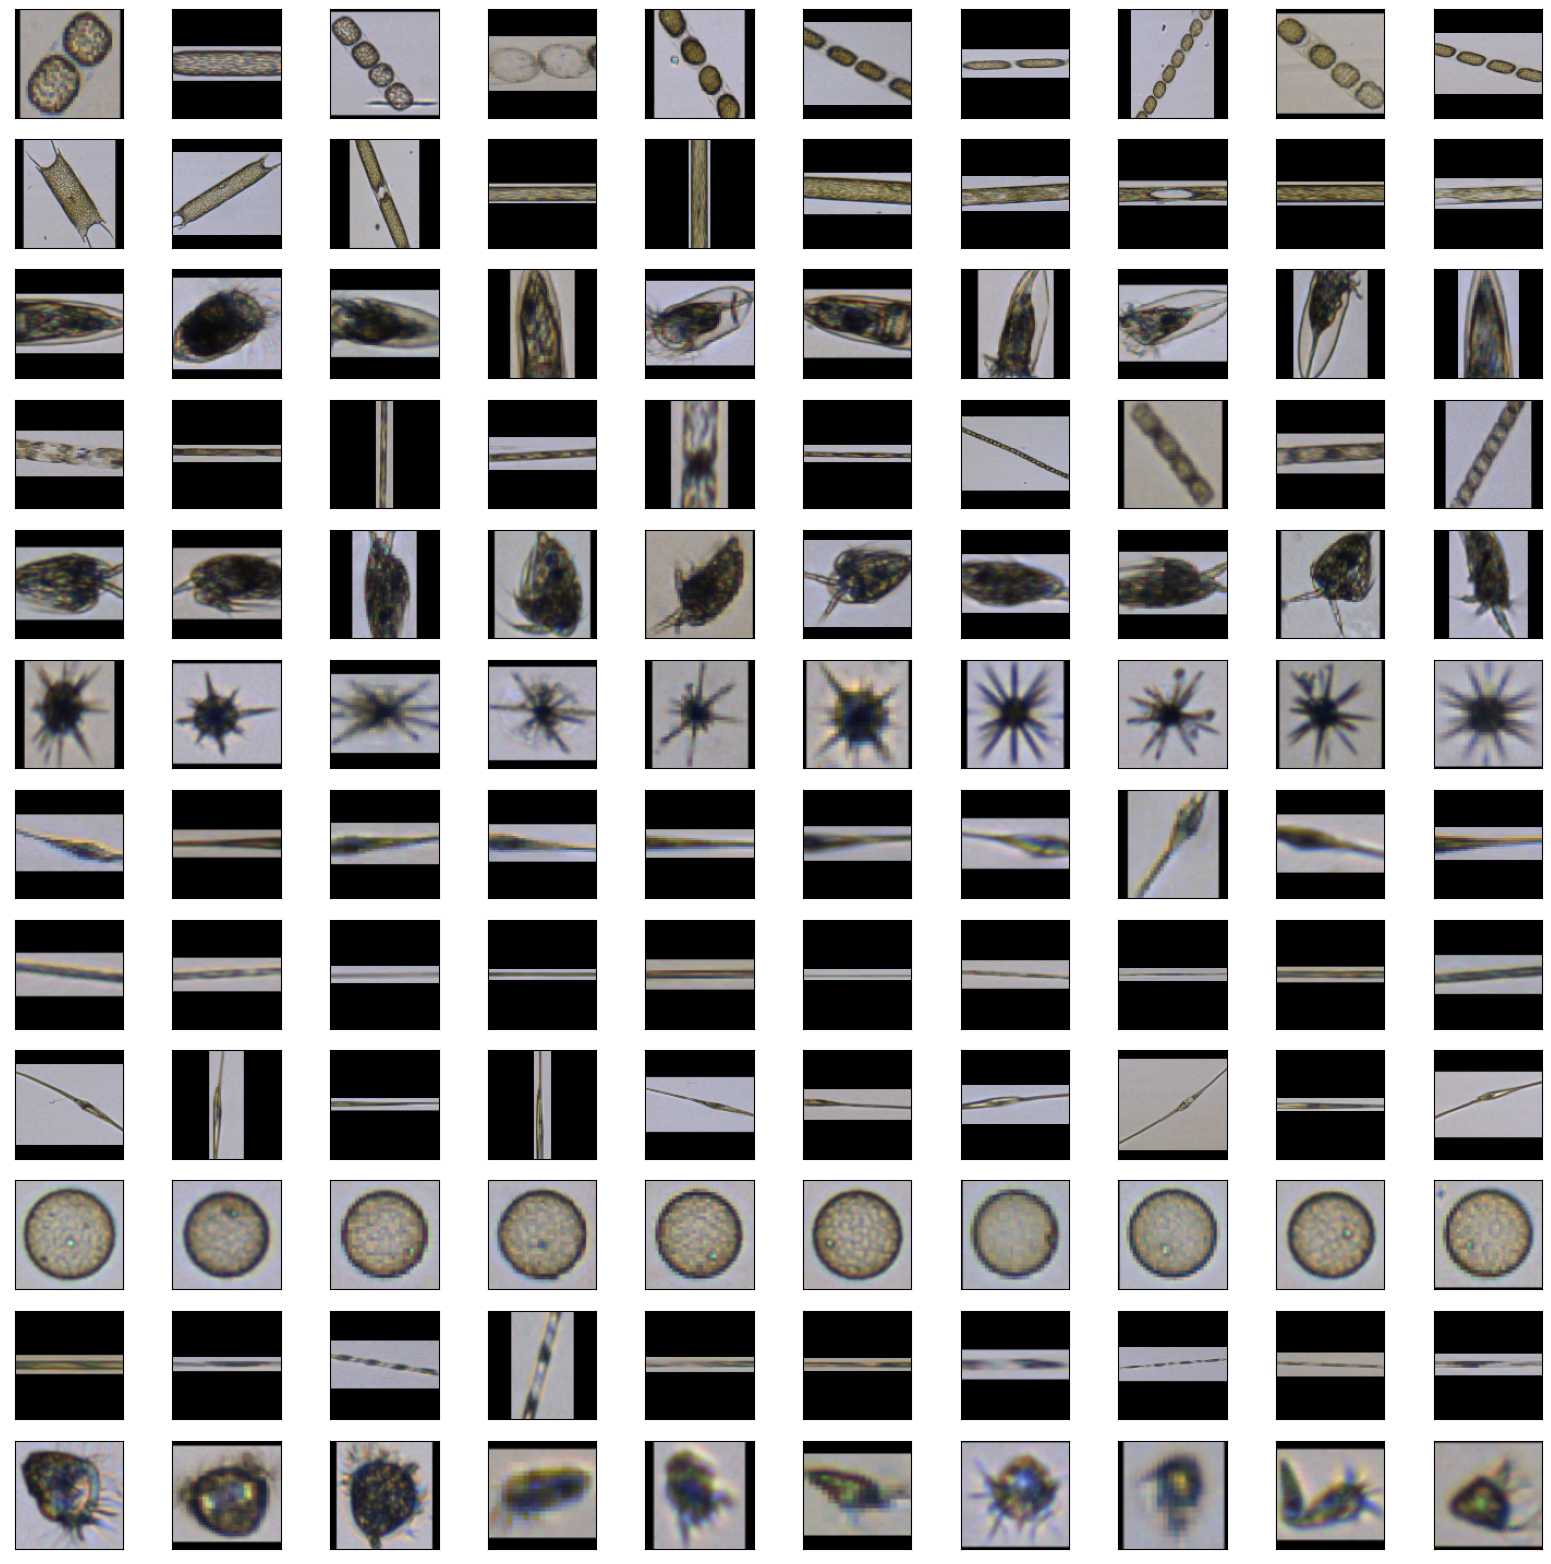

In [2]:
data = torch.load('plankton.pt')

# get the number of different classes
classes = data['labels'].unique()
nclasses = len(classes)
print('The classes in this dataset are: ')
print(classes)

# display the number of instances per class: 
print('\nAnd the numbers of examples per class are: ')
print( pd.Series(data['labels']).value_counts() )

# we now print some examples from each class for visualisation
fig = plt.figure(figsize=(20,20))

n = 10 # number of examples to show per class

for i in range(nclasses): 
  idx = data['labels'] == classes[i]
  imgs = data['images'][idx,...]
  for j in range(n):
    ax = plt.subplot(nclasses,n,i*n+j+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow( imgs[j,...].permute(1, 2, 0) ) # note the permute because tensorflow puts the channel as the first dimension whereas matplotlib expects WxHx3
plt.show()


## Exploring the data

Histogram showing class distribution in our data. We observe high imbalance across classes with class [2.0, 7.0, 8.0] having the highest number of samples. Similarly classes [1.0, 4.0 and 5.0] have the lowest number of samples in the dataset. Using this data distribution for training will likely cause our model to be biased towards high frequency samples and fail to obtain sufficient learning to be able to detect images belonging to the minority classes. We implement specific techinques to address class imbalance in the later sections. 

c:\Users\Anirbit\anaconda3\envs\DLearn\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


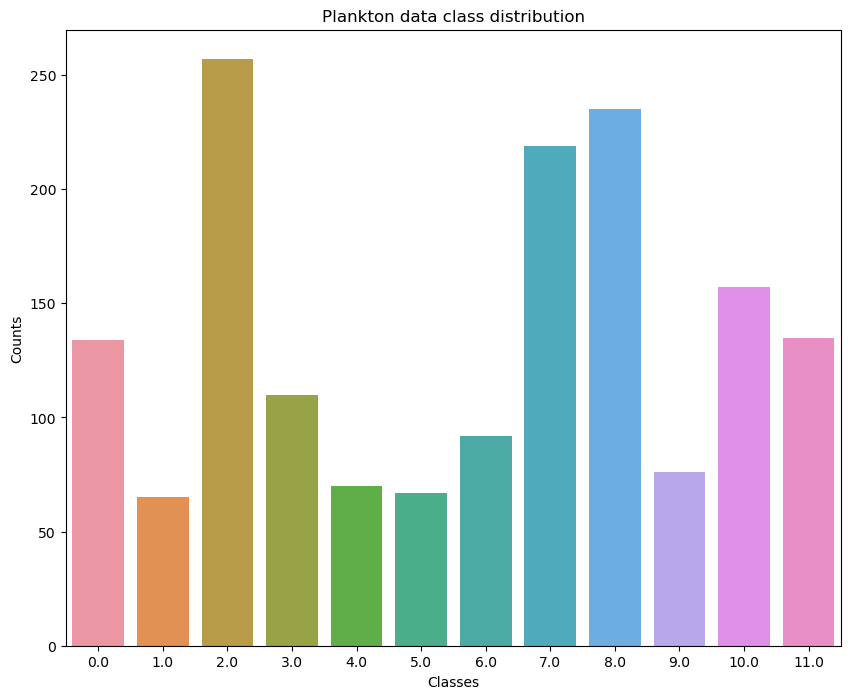

In [3]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.countplot(pd.Series(data['labels']))
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("Plankton data class distribution")
plt.show()

# Data pre-processing

### Custom dataset class

We create a custom dataset class that inherits from Pytorch Dataset. It takes as input a dictionary with image tensors under the key 'images' and labels for each image under the key 'labels'. It also accepts an optional transformer parameter to augment the data. We instantiate our custom Dataset class with the full plankton data. Each datapoint accessed from the dataset class is returned as a tuple containing the image tensor and the corresponding class label. Each image before being returned is transformed using any provided transformer function. The dataset also supports accessing multiple images using slicing or lists of indices. 


In [4]:
from torch.utils.data import Dataset
from torch.utils.data import random_split
from collections import Counter
from torch.utils.data import DataLoader
import copy
torch.manual_seed(1)
np.random.seed(1)

class PlanktonDataset(Dataset):
  def __init__(self, data, transform=None):
    self.images = data['images']
    self.labels = data['labels']
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    if isinstance(index, slice):
      start = 0 if index.start == None else index.start
      stop = -1 if index.stop == None else index.stop
      step = 1 if index.step == None else index.step
      imgs = []
      for idx in range(start, stop, step):
        img = self.images[idx]
        if self.transform:
          img = self.transform(img)
        imgs.append(img)
      return imgs, self.labels[start:stop:step]

    else:
      img = self.images[index]
      if self.transform:
        img = self.transform(img)
      return img, self.labels[index]

plankton_dataset = PlanktonDataset(data)

### Data Normalization

Before using our image data in training or classificationt tasks, we have normalized it to [-1, 1] range. This makes our images have a mean = 0 and std dev = 1 which enables our model to converge better in the right direction when pixel values are distributed normally across a zero center.This normalization is aimed at allowing our model to extract better features from the images such that the calculated gradients can converge in the right direction and provide better learning. In order to find the values to be used as parameters in the PyTorch normalization transformer (transforms.Normalize()), we calculated the mean and std dev across each channel of our raw image tensor data as show below. We loaded the data into our custom dataset class and created a temporary dataloader to get batches of images and calculate the mean and std dev across batches. We then used the obtained values as the parameters in the Normalize transformer. 

In [5]:
def batch_mean_and_sd(loader):
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (
                      cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (
                            cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(
      snd_moment - fst_moment ** 2)        
    return mean, std

temporary_data_loader = DataLoader(plankton_dataset, batch_size=64)
data_mean, data_std = batch_mean_and_sd(temporary_data_loader)

print(f"Our data's mean : {data_mean} and standard deviation : {data_std}")


Our data's mean : tensor([0.3038, 0.2968, 0.2984]) and standard deviation : tensor([0.3094, 0.3038, 0.3112])


### Data augmentation

We observe that the total dataset is relatively small for the purpose of effectively training a Deep Convolutional Neural Network. Therefore, I have implemented a data augmentation pipeline to increase the diversity of our dataset. This is aimed to effectively increase the number of distinct images we use to train our network with by adding random variations of each image into the dataset. We have used PyTorch transformers to augment our dataset. Here we set up the augmentation function for the training and the test set. We add no transfomrations to the test set besides normalization as our model is trained on normalized images. For the trianing set, we perform random horizontal and vertical flips with p=0.5 and random rotation at 30 degrees. This was chosen based on the appearance of images in each class. Some classes display rotational and translational symmetry in the plankton structures whereas majority of classes do not. Therefore, by adding random rotations and flips, we aim to achieve rotational and translational invariance in our model such that it can learn how to characterize each class irrespective of the spatial orientation of the image. 

In [6]:
import torchvision.transforms as transforms

def train_transformer():
  train_transformer = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.RandomVerticalFlip(0.5),
      transforms.RandomRotation(30),
      # transforms.Normalize(data_mean,
      #                      data_std)
  ])
  return train_transformer

def test_transformer():
  test_transform = transforms.Compose([
    # transforms.Normalize(data_mean,
    #                        data_std),
  ])
  return test_transform

Demonstrating transformations results on each class - Images are randomly rotated and flipped along with pixel values being normalized to [-1, 1]. This displays the data we expect to see in our training dataset.

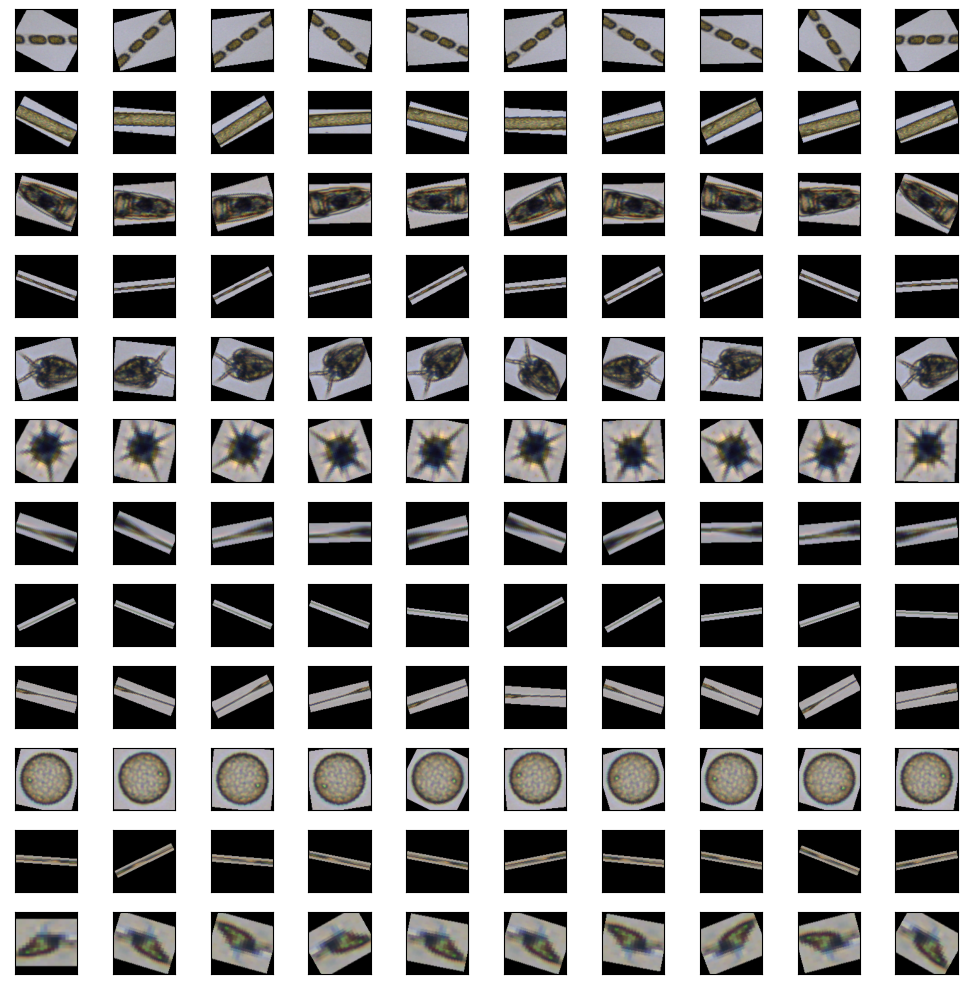

In [7]:
num_transforms = 10
transform = train_transformer()

fig = plt.figure(figsize=(10,10))
for i in range(nclasses): 
  idx = data['labels'] == classes[i]
  imgs = data['images'][idx,...]
  for j in range(num_transforms):
    ax = plt.subplot(nclasses, num_transforms, i*num_transforms+j+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img_toshow = np.array(transform(imgs[5])).transpose(1, 2, 0)
    clipped = np.clip(img_toshow, 0, 1)
    # ax.imshow(np.array(transform(imgs[5])).transpose(1, 2, 0))
    ax.imshow(clipped)
plt.tight_layout()

### Splitting the dataset

Now we take the entire dataset and use the random_split function to perform a 90%-10% split to obtain a separate test set we will evaluate our trained model on. The 90% of the data is used in training and cross-validation. We avoid splitting a separate validation set as that was making our model's performance worse by reducing the available training data significantly such that minority classes would get very few samples, leading to poor learning for those classes.

In [8]:
train_split, test_split = random_split(plankton_dataset, [0.9, 0.1])

Exploring the data split by plotting histograms of the class distribution in train and test. We again plot the class distribution of each data split so we can observe if we are getting even allocation of classes across both sets. The histogram proves that our split is maintaing a reasonable balance between the classes such that no class is getting disproportionately fewer or more samples in either datset. Both, training and test sets, maintains the same distribution ratio between majority and minority classes as the overall dataset. 

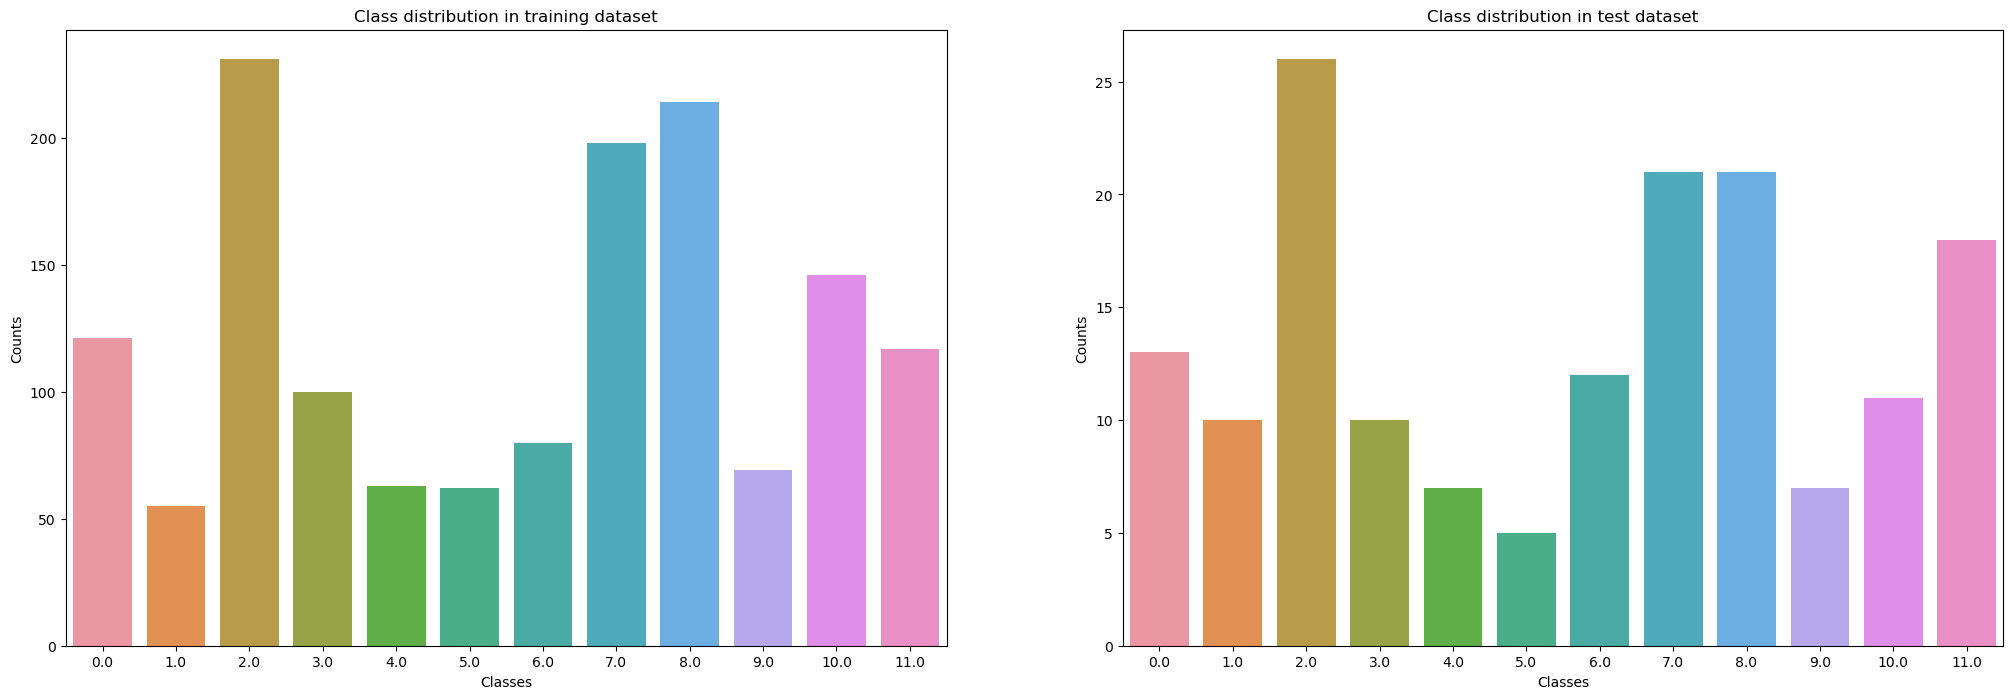

In [9]:
train_labels, test_labels = [], []
train_images, test_images = [], []

for img, label in train_split:
  train_images.append(img)
  train_labels.append(label.numpy())

for img, label in test_split:
  test_images.append(img)
  test_labels.append(label.numpy())

fig, axes = plt.subplots(1, 2, figsize=(25,8))

sns.countplot(x=np.array(train_labels), ax=axes[0])
axes[0].set_title("Class distribution in training dataset")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Counts")

sns.countplot(x=np.array(test_labels), ax=axes[1])
axes[1].set_title("Class distribution in test dataset")
axes[1].set_xlabel("Classes")
axes[1].set_ylabel("Counts")

plt.show()

### Create datasets from the split data

We create our custom Dataset class instance for each of the two data split - train and test - and provide the relevant data transformers to each dataset

In [10]:
train_data = {
    'images' : torch.stack(train_images), 
    'labels' : torch.tensor(np.array(train_labels))
}

test_data = {
    'images' : torch.stack(test_images), 
    'labels' : torch.tensor(np.array(test_labels))
}

train_transform = train_transformer()
test_transform = test_transformer()

train_dataset = PlanktonDataset(train_data, transform=train_transform)
test_dataset = PlanktonDataset(test_data, transform=test_transform)

# Class Weighting

To deal with the class imbalance in the dataset I have first calculated the respective weights of each class in our dataset as the reciprocal frequency of the class. The more number of samples we have for a class, the lower its weight compared to classes with relatively fewer samples. These weights are calculated by our calc_weights() function which counts the occurence of each class label in the overall data provided and returns a tensor containing the weights for each of the 12 classes. 

Based on the concept of class weights, I have implemented a FocalLoss (Lin T. et al. 
https://doi.org/10.48550/arXiv.1708.02002) function which modifies the base CrossEntropy loss to compensate for imbalanced class distribution in our dataset. The CE loss is dynamically scaled, by the parameter `gamna` to weigh down the contribution of "easy" samples having higher occurence in the data during the training process while allowing the model to focus on "hard" classes with low data availability. We pass in the individual class weights of our data calculated previously as a tensor in the `weight` parameter to allow our loss function to determine which classes should be weighed down. 

In [11]:
from torch.autograd import Variable
import torch.nn.functional as F

def calc_weights(total_data):
    class_weights = []
    class_counts = pd.Series(total_data['labels']).value_counts()
    for c in classes:
        class_weights.append(class_counts[c])
        
    return 1.0/torch.tensor(class_weights, dtype=torch.float32)

class_weights = calc_weights(data)
print("Class weights for each class label in our dataset : ", class_weights)


# def assign_weights(subset, weights):
#     sample_weights = []
#     for label in subset[1]:
#         sample_weights.append(weights[int(label.numpy())])

#     return torch.tensor(sample_weights, dtype=torch.float32)

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

Class weights for each class label in our dataset :  tensor([0.0075, 0.0154, 0.0039, 0.0091, 0.0143, 0.0149, 0.0109, 0.0046, 0.0043,
        0.0132, 0.0064, 0.0074])


## Model

Here we implement the final version of our chosen architecture. For our multi-class, single-label classification task, I have chosen to implement a Convolution Neural Network. The network is implemented with customizable parameters to allow easier parameter tuning. The architecture of the CNN is based on the standard ConvNet architecture, but simplified further to 2 conv layers and 1 Fully Connected layer due to the overfitting observed when using more complex layer structures. The convolutions are performed with a standard 3x3 kernel with zero padding and stride = 1. We use a utility function `findConv2dOutShape()` to calcualte the output size of each convolution to be used as the input size for the next layer saving us from having to manually calculate input and output feature dimensions for each layer. The first conv layers take as input a RBG 100x100x3 and convolves it using 8 total filters (provided as the `init_f` parameter). This generates an output of dimension 98x98x8. Then the maxpool layer uses a kernel of size 2 with stride = 2, to reduce the pixel dimnesions of output of the conv layer by a factor of 2 - producing a 49x49x8 feature. Each conv layer effectively doubles the number of channels while the maxpool halves the dimensions.  The final output of the conv layers is flattened into a 8464 element 1d tensor which is subject to a 20% dropout layer. This drops 20% random connections from the previous layers to make training more robust by introducing random noise into the extracted features. This 1d tensor is then passed to the Linear fully connected layer, with no activation function, to produce an output of a 12 element tensor. Each element containing the logit values showing the probability of the input belonging to each of the 12 classes in our data. 

A ReLU activation is applied to the output of each hidden layer and then it is max pooled. We chose max pooling as the images we deal with have a very distinct separation between the background and foreground. By selecting the largest value from the convolved kernel, we expect our model to capture the structural outline of the subject in each image as there is a sharp separation between the high intensity background and the lower intensity plankton body. The choice of ReLU as the activation function was made as it is the state-of-the-art activation function for multi-class classication and our pixel values being in range [0,1] would allow ReLU to introduce non-linearity to our our hidden layers and prevent vanishing gradient problems. We ultimately use a single fully connected layer to produce our classified outputs which generates logit values corresponding to each class. 

### Model Util functions

In [12]:
def findConv2dOutShape(H_in, W_in, conv, pool = 2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        H_out /= pool
        W_out /= pool
    
    print("height out: " , str(H_out), "Width out : " , str(W_out))
    return int(H_out), int(W_out)


### Network implementation

In [13]:
class Net(nn.Module):
  def __init__(self, params):
    super(Net,self). __init__()
    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"]
    num_fc1=params["num_fc1"]
    num_classes=params["num_classes"]
    self.dropout_rate=params["dropout_rate"]

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h,w=findConv2dOutShape(H_in,W_in,self.conv1)
    
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv2)

    # compute the flatten size
    self.num_flatten=h*w*2*init_f
    self.fc2 = nn.Linear(self.num_flatten, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x=F.dropout(x, self.dropout_rate)
    x = self.fc2(x)
    return x

device = torch.device("cuda")

### Implementing training functions

Here we implement our training loops. It uses a 5 fold cross validation implemented using Scikit-Learn's KFold class. It takes the number of folds and generates indices representing a training (4/5th) and validation (1/5th) set. We use the indices to sample data subsets from our `train_dataset` using a `SubsetRandomSampler`. At each fold we also instantiate a new model to ensure the weights are reset and no learning leaks over across each fold. We then create DataLoaders for the training and validation data subsets with a batch size of 64 and provide the created samplers to the DataLoader so that when sampling a batch of data it only selects images belonging to the training and validation indices respectively, as generated by the KFold algorithm. We choose to use an `Adam` optimizer with lr=0.003 and a instantiate our `FocalLoss` as defined earlier with gamma=1 and weight=weights of each class in the data. We used the `Adam` optimizer over `SGD` as it maintains a separate learning rate for each neuron and can independently update the lr to improve overall model learning. We also keep track of the validation loss and accuracy of each fold and save the model after the last fold. 

We created a second training function which does the actual model training over the epochs inside each fold of the Kfold algorithm. This `train_epoch` function is provided all the training parameters including loss function, optimizer, train and validation dataloaders and the number of epochs. The training then follows a very standard approach, iterating over each data batch, generating the model output for each image in the batch, calculating the FocalLoss value relative to the ground truth labels, then backpropagating the loss and updating the neuron weights using the optimizer. We perform a similar process on the validation dataset, without actually updating any gradients, instead we simply measure the performance metrics (accuracy) and the loss values for each data batch.

In [23]:
from torch import optim
from torch.utils.data import DataLoader, SubsetRandomSampler, WeightedRandomSampler
from sklearn.model_selection import KFold, StratifiedKFold

def train_epoch(train_params, model):
  num_epochs=train_params["num_epochs"]
  loss_func=train_params["loss_func"]
  opt=train_params["optimizer"]
  train_dl=train_params["train_dl"]
  val_dl=train_params["val_dl"]

  loss_hist = {
  "train": [],
  "val" : []
  }
  acc_hist = {
      "train": [],
      "val" : []
  }

  for epoch in range(num_epochs):
    with torch.no_grad():
      valid_loss = 0
      num_right = 0 
      
      for xb, yb in val_dl:
        yb = yb.type(torch.LongTensor)
        xb = xb.to(device)
        yb = yb.to(device)

        output = model(xb)
        loss = loss_func(output, yb)
        valid_loss += loss.item() * len(xb)
        preds = output.argmax(dim=1, keepdim=True)
        num_right += preds.eq(yb.view_as(preds)).sum().item()
      
      loss_hist["val"].append(valid_loss/len(val_dl.sampler.indices))
      acc_hist["val"].append(num_right / len(val_dl.sampler.indices))

      if epoch % 20 == 0:
        print('Valid Loss: {} Accuracy: {} Epoch:{}'.format(valid_loss/len(val_dl.sampler.indices), num_right/len(val_dl.sampler.indices), epoch))

    
    train_loss = 0
    num_right = 0
    for xb, yb in train_dl:
      yb = yb.type(torch.LongTensor)
      xb = xb.to(device)
      yb = yb.to(device)
      opt.zero_grad()
      output = model(xb)
      loss = loss_func(output, yb)
      loss.backward()
      opt.step()

      train_loss += loss.item()*len(xb)
      preds = output.argmax(dim=1, keepdim=True)
      num_right += preds.eq(yb.view_as(preds)).sum().item()
  
    loss_hist["train"].append(train_loss/len(train_dl.sampler.indices))
    acc_hist["train"].append(num_right / len(train_dl.sampler.indices))

    
    if epoch % 20 == 0:
      print('Loss: {} Accuracy: {} Epoch:{}'.format(train_loss/len(train_dl.sampler.indices), num_right / len(train_dl.sampler.indices), epoch))
    
  return loss_hist, acc_hist

def kfold_train(model_params, lr_param, batch_size_param, model_name):
  kfolds = 5
  kfold = KFold(n_splits=kfolds, shuffle=True, random_state=1)

  loss_list = []
  acc_list = []
  
  # train_data['images'], train_data['labels']

  for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_dataset)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    train_subsampler = SubsetRandomSampler(train_idx)
    valid_subsampler = SubsetRandomSampler(valid_idx)
    
    model = Net(model_params)
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size_param, sampler=train_subsampler)
    validation_loader = DataLoader(train_dataset, batch_size=batch_size_param, sampler=valid_subsampler)
    
    optimizer = optim.Adam(model.parameters(), lr=lr_param)
    # loss_func = nn.CrossEntropyLoss()
    loss_func = FocalLoss(gamma=1)
    
    
    params_train={
        "num_epochs": 100,
        "optimizer": optimizer,
        "loss_func": loss_func,
        "train_dl": train_loader,
        "val_dl": validation_loader,
    }

    loss, accuracy = train_epoch(params_train, model)
    
    loss_list.append(loss["val"][-1])
    acc_list.append(accuracy["val"][-1])

    if fold == kfolds-1:
      torch.save(model.state_dict(), model_name)

  print('Training Ended')
  print('Average Loss: {} Average Accuracy: {}'.format(np.mean(loss_list), np.mean(acc_list)))

  return loss_list, acc_list, loss, accuracy

### Model training

In [293]:
# # %%script false --no-raise-error
params_model = {
    "input_shape" : (3, 100, 100),
    "initial_filters" : 8,
    "num_fc1" : 100,
    "dropout_rate" : 0.25,
    "num_classes" : 12,
}

lr = 0.003
batch_size = 64
model_save_name = "100epoch_5fold_2conv_non_normalized_focal_model10.pt"
fold_loss, fold_acc, loss_hist, acc_hist = kfold_train(params_model, lr, batch_size, model_save_name)

FOLD 0
--------------------------------
height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
Valid Loss: 2.4811297344834835 Accuracy: 0.13356164383561644 Epoch:0
Loss: 2.213413700615008 Accuracy: 0.21477663230240548 Epoch:0
Valid Loss: 1.1781570062245408 Accuracy: 0.5821917808219178 Epoch:20
Loss: 1.0974453208372765 Accuracy: 0.5584192439862543 Epoch:20
Valid Loss: 1.1133277089628455 Accuracy: 0.5958904109589042 Epoch:40
Loss: 0.9560014214302666 Accuracy: 0.627147766323024 Epoch:40
Valid Loss: 1.1997656912019807 Accuracy: 0.5582191780821918 Epoch:60
Loss: 0.8515717319606506 Accuracy: 0.6486254295532646 Epoch:60
Valid Loss: 1.4429792378046742 Accuracy: 0.5513698630136986 Epoch:80
Loss: 0.7516064764707768 Accuracy: 0.7079037800687286 Epoch:80
FOLD 1
--------------------------------
height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
Valid Loss: 2.480254133132725 Accuracy: 0.08247422680412371 Epoch:0
Loss: 2.1531633208238006 Accuracy: 0.2557939914163

# Evaluating different classification models produced

In this section I have demonstrated how I have gradually improved my classification system to arrive at the final version. The changes made involve altering the model architecture, trying different data pre-processing and data validation steps. I have trained and saved a model for each set of changes implemented and evaluated its performance by calculating the metrics - accuracy, precision and recall - on a held out test set. 

To evaluate each model I have used the following functions to calculate classification metrics and plot a confusion matrix to visualize predictions

In [26]:
from sklearn import metrics

def read_model(network, weights):
    params_model = {
        "input_shape" : (3, 100, 100),
        "initial_filters" : 8,
        "num_fc1" : 100,
        "dropout_rate" : 0.25,
        "num_classes" : 12,
    }
    model = network(params_model)
    checkpoint = torch.load(weights)
    model.load_state_dict(checkpoint)
    
    return model

def calc_accuracy(preds, target):
    correct = 0 
    for i in range(len(preds)):
        if preds[i] == target[i]:
            correct += 1
    return correct / len(preds) * 100

def calc_recall(cm):
    tp = np.diag(cm)
    tp_fn = np.sum(cm, axis=1)
    recall = np.where(tp_fn == 0, tp_fn, tp/tp_fn)
    # return np.mean(np.diag(cm) / np.sum(cm, axis=1))
    return recall.mean()

def calc_precision(cm):
    tp = np.diag(cm)
    tp_fp = np.sum(cm, axis=0)
    prec = np.where(tp_fp == 0, tp_fp, tp/tp_fp)
    # return np.mean(np.diag(cm) / np.sum(cm, axis=0))
    return prec.mean()

def plot_confusion_matrix(model, dataset):
    preds = []
    target = []
    for image in dataset:
        pred = torch.max(model(image[0]).data, 1)[1].item()
        preds.append(pred)
        target.append(image[1].item())

    preds = np.array(preds).astype(np.float32)
    target = np.array(target).astype(np.float32)

    plt.figure(figsize=(7,7))
    ax = plt.subplot()
    conf_mat = metrics.confusion_matrix(target, preds)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat)

    sns.heatmap(conf_mat, annot=True, fmt='g', cmap=sns.color_palette("rocket_r", as_cmap=True))
    ax.set_xlabel("Predicted")
    ax.set_ylabel('True')
    ax.set_title("Confusion Matrix")
    plt.show()
    
    return conf_mat, preds, target
    

### Model 01 - First baseline

The first model I developed had the following architecture. It included 4 hidden convolutions and 2 fully connected layers. For this model, I randomly split the dataset into training (80%), validation (10%) and test sets (10%) maintaining equal class distribution in each split (no cross validation as used on our final model version). I also used data augmentation including random horizontal & vertical flips and random rotation to augment our limited training data. Additionally, I used the same dataset class to create the dataloaders with batch size 64 and passed the augmentation transforms into the dataloaders. This model used an `Adam` optimizer, `CrossEntropy` loss with learning rate = 0.003 and was trained over 100 epochs, while using the dedicated validation set to calcualte validation loss and accuracy at each iteration. 

In [53]:
class First_Net(nn.Module):
  def __init__(self, params):
    super(First_Net,self). __init__()
    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"]
    num_fc1=params["num_fc1"]
    num_classes=params["num_classes"]
    self.dropout_rate=params["dropout_rate"]

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h,w=findConv2dOutShape(H_in,W_in,self.conv1)
    
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv2)
    
    self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv3)

    self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv4)

    # compute the flatten size
    self.num_flatten=h*w*8*init_f
    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x = F.relu(self.fc1(x))
    x=F.dropout(x, self.dropout_rate)
    x = self.fc2(x)
    return x


#### Analysis
The classification performance metrics of the Model 01 are shown below. We obtain an accuracy of around 30%, a recall and precision of 0.25. The low recall also indicates that out of all correct predictions for each class our model predicts a very small fraction of samples correctly. Similarly a low precision indicates majority of predictions for each class were incorrect. This is seen in the confusion matrix as we observe no predictions for classes 1.0, 4.0 and 5.0. These classes had the lowest number of data samples. Our choice of extracting a dedicated validation set from the already low training samples made this even worse as our model did not have enough data to accurately learn how to classify images into those classes. This is an indication of underfitting. Furthermore, out of the samples predicted incorrectly most of them were assigned a class of 2.0, 7.0, 8.0 or 10.0, as they had the highest number of training samples. Therefore, this model was clearly a poor baseline where it did not learning anything significantly meaningful. The reason was primarily the class imbalance in the data leading to very poor distribution of training samples when split into 3 separate datasets.

height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
height out:  10.5 Width out :  10.5
height out:  4.0 Width out :  4.0


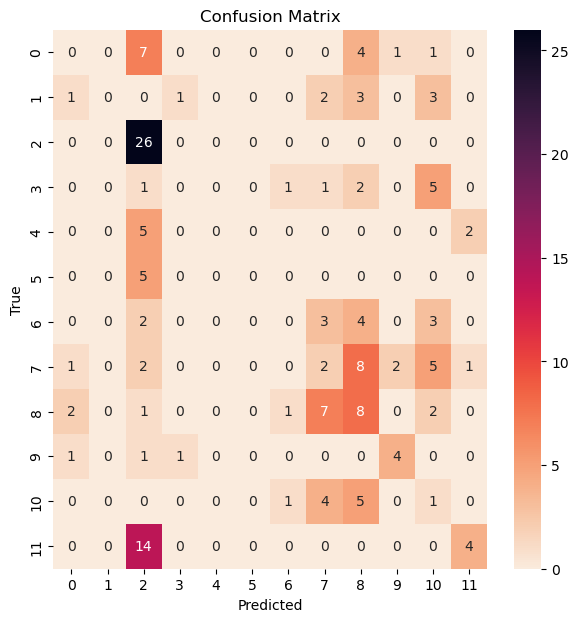

Model_01 Accuracy : 27.950311 % || Model_01 Recall : 0.196729 || Model_01 Precision : 0.161639


C:\Users\Anirbit\AppData\Local\Temp\ipykernel_12896\1354240392.py:34: RuntimeWarning: invalid value encountered in true_divide
  prec = np.where(tp_fp == 0, tp_fp, tp/tp_fp)


In [54]:
model_01 = read_model(First_Net, "models/100epoch_01_model.pt")

conf_mat_01, predictions_01, targets_01 = plot_confusion_matrix(model_01, test_dataset)
accuracy_01 = calc_accuracy(predictions_01, targets_01)
recall_01 = calc_recall(conf_mat_01)
predictions_01 = calc_precision(conf_mat_01)

print("Model_01 Accuracy : %f %% || Model_01 Recall : %f || Model_01 Precision : %f"%(accuracy_01, recall_01, predictions_01))

### Model 02 - Simplified network architecture

Learning from the previous model instance, here I have tried a different approach to train the CNN. I noticed a lot of the inaccuracies were caused by lack of data for certain classes in the training set. Therefore, for the second model I chose to use a K-fold cross validation approach to take advantage of the limited data and perform validation on a held-out set at each iteration. I split the data into a 90-10 train-test split, with no dedicated validation set this time. Then I trained the CNN using a 5-fold cross validation on the training set, where the model is trained on 80% of data and validated on the held-out fold of 20% data. After each iteration we replace one of the training folds with the previous validation fold and repeat the process. Additionally, I also reset the network weights after training is completed on each data fold such that learning does not leak across folds. This cross-validation approach took longer to train as we performed 100 training epochs for 5 total folds. All other network and training parameters were kept the same as the previous model. 

#### Analysis

As observed from the results below, adding 5-fold cross validation produced a significant increase in model performance. We get an average validation accuracy of 66% across 5 folds and on the test dataset we get a **68%** accuracy with precision and recall of **0.70**. This signifies that our model was able to classify images much better by using the limited amount of available data more efficiently when we dont reduce the dataset by extracting a separate validation set. One major improvement we observe from the previous model is that there is no class which gets zero predictions indicating our model is able to sufficiently learn features even for classes with low distribution of samples in the dataset. The precision value indicates that the model predicts around 60% of samples belonging to each class correctly. 

Majority of incorrect predictions were made between classes 7.0 and 8.0. This is likely because those two classes had a high number of data samples while having a very similar structural appearance to each other. Other classes, particularly 10.0 and 3.0 possessing a similar appearance to class 7.0 and 8.0 were incorrectly predicted as those classes indicating that our model predictions are biassed towards classes with high data. This is particularly visible in the predictions of class 3.0 - that class showed the highest inaccuracies with most samples belonging to class 3.0 being predicted as 1.0, 7.0 or 8.0. Going back and looking at the images of those classes we observe a similar elongated structure in all of them and class 3.0 having the lowest amount of samples in the data prevents our model from effectively learning features on how to differentiate images in that class from other classes that look alike. This could be a result of our model learning too much of the most minor details such as random noise from the images in classes with more data and failing to capture enough information about the less dominant classes, leading to poor generalization. This observation combined with the fact that our model didn't generalize equally well on unseen data as it did on training data, could be a sign that this model is likely to be overfitted to the data. 

height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
height out:  10.5 Width out :  10.5
height out:  4.0 Width out :  4.0


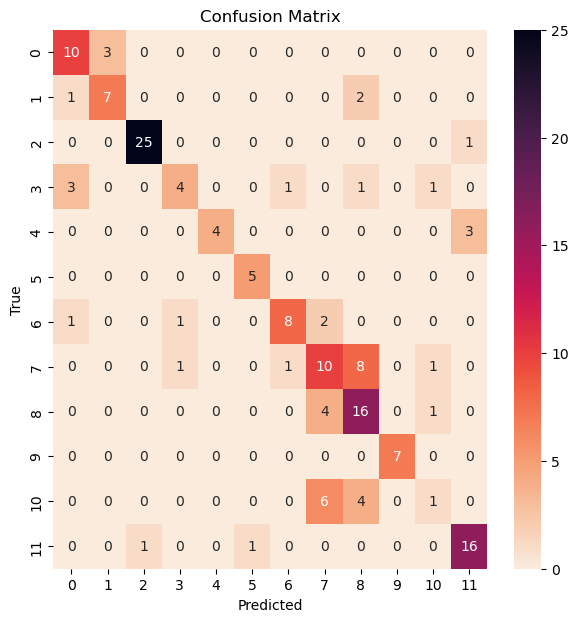

Model_02 Accuracy : 70.186335 % || Model_02 Recall : 0.690563 || Model_02 Precision : 0.720740


In [75]:
model_02 = read_model(First_Net, "models/100epoch_5fold_4conv_model02.pt")

conf_mat_02, predictions_02, targets_02 = plot_confusion_matrix(model_02, test_dataset)
accuracy_02 = calc_accuracy(predictions_02, targets_02)
recall_02 = calc_recall(conf_mat_02)
predictions_02 = calc_precision(conf_mat_02)

print("Model_02 Accuracy : %f %% || Model_02 Recall : %f || Model_02 Precision : %f"%(accuracy_02, recall_02, predictions_02))

### Model 03 - Add cross validation

Based on the model 02, it was discovered that the model showed indications of overfitting to our data. This was likely caused by our choice of network architecture having 4 convolution layers with 2 fully connected layers. Considering our data consists of small (100x100px) images which are structurally very simple, multiple layers can increase the model complexity such that it learns to characterize even the minor noisy features present in the images. In order to minimize overfitting I simplified the network architecture to include 2 convolutions and 1 fully connected layer while keeping all other model and training parameters the same. This architecture is shown below: 

In [76]:
class Second_Net(nn.Module):
  def __init__(self, params):
    super(Second_Net,self). __init__()
    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"]
    num_fc1=params["num_fc1"]
    num_classes=params["num_classes"]
    self.dropout_rate=params["dropout_rate"]

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h,w=findConv2dOutShape(H_in,W_in,self.conv1)
    
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv2)

    # compute the flatten size
    self.num_flatten=h*w*2*init_f
    self.fc2 = nn.Linear(self.num_flatten, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x=F.dropout(x, self.dropout_rate)
    x = self.fc2(x)
    return x

#### Analysis
Upon using a simpler network we observe an improvement in classification performance. Our simpler model, with the same training process, generated classfication accuracy of 75% on the test dataset along with recall of 0.77 and precision of 0.77. Furthermore, the improvement observed in the test data performance, indicates that a simpler model avoids overfitting and learns how to characterize each class much better when working on unseen images as simple as the plankton data. The higher precision indicated more samples from each class were predicted correctly implying lesser incorrect predictions. However, the recall does not improve as much from the previous model indicating overall the model still misidentifies about 30% of correct predictions. 

From the predictions results in the confusion matrix, we observe classes 7.0 and 8.0 were still being confused quite a lot and as supported by the low improvement in the recall score, some classes are still being misclassified as 7.0 and 8.0 due to them having more data samples. We observe images of class 10.0 being predicted with the highest error rate, with them most frequently being assigned to class 7.0 or 8.0. The main reason behind these prediction inaccuracies is likely the similaritiy in appearance between those classes. And due to the imbalanced class distribution present in the training data, predictions for image that have similar appearance become biased towards the class having more data. Though our simpler model does not overfit and generalizes better to unseen data, the bias caused by classes with large number data samples is still causing most of the errors observed. 

height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5


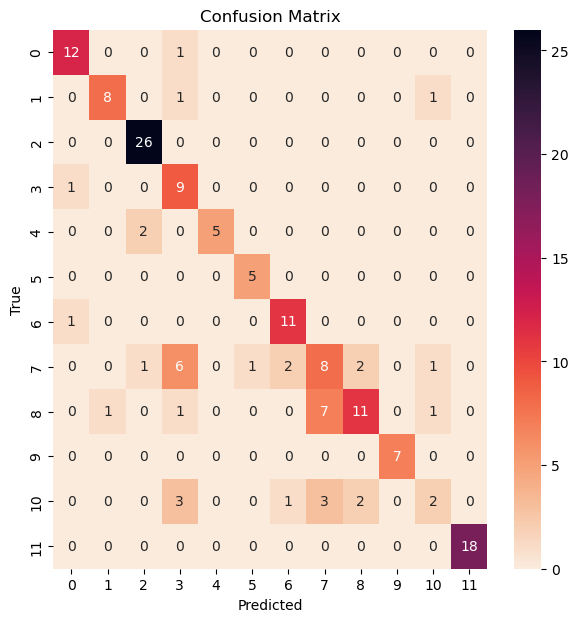

Model_03 Accuracy : 75.776398 % || Model_03 Recall : 0.778384 || Model_03 Precision : 0.772332


In [119]:
model_03 = read_model(Second_Net, "models/100epoch_5fold_2conv_model03.pt")
# models/100epoch_5fold_2conv_model03.pt

conf_mat_03, predictions_03, targets_03 = plot_confusion_matrix(model_03, test_dataset)
accuracy_03 = calc_accuracy(predictions_03, targets_03)
recall_03 = calc_recall(conf_mat_03)
predictions_03 = calc_precision(conf_mat_03)

print("Model_03 Accuracy : %f %% || Model_03 Recall : %f || Model_03 Precision : %f"%(accuracy_03, recall_03, predictions_03))

### Model 4 - Add weighted FocalLoss

Based on the previous iteration of the model, it was discovered that class imbalances caused a large bias for dominant classes resulting in predictions being skewed towards those classes. Particularly, class 7.0 and 8.0 as they share similar structural  characteristics to several other classes like class 1.0, 3.0 and 10.0, all having less data than 7.0 and 8.0. The similar appearance made it hard for the model to identify exactly which class the image belongs to and ended up making a prediction for the class it was able to learn the most features from. Therefore it was essential to implement some balancing techniques to mitigate this effect. 

For this model I added the weighted loss function (as explained previously in Class Weighting section) to reduce the effect of class imbalance in our training data. We first calculated the weight for each class as the reciprocal of the class frequency as seen in the training set. Then we initialized the custom FocalLoss function with gamma=1 and weights = weight of each class in our data. This weighted loss function was used to train the model to reduce biases created by disproportionate class distribution.

#### Analysis

Upon adding the class weighted FocalLoss to our model, we immediately observed a significant improvement in prediction performance. As shown in the confusion matrix below, we observe much fewer predictions being confused as the dominant class 7.0 or 8.0. In fact some images belonging to the dominant class 8.0 were predicted as being class 10.0. This supports our loss function's effectiveness as it is successfully reducing the contribution of the larger classes in the model and assigning minority classes a higher importance. This behaviour is also observed in a few images that actually belong to class 2.0, the most dominant class in the data, but were predicted as class 4.0 which shares physical similarities to class 2.0. Therefore, our focal loss effectively compensates for the data imbalance by preventing dominant classes from drowning out all other classes. 

Overall, this increases the likelihood of better classification as not all images of planktons that share structural similarities will be biased towards the class with the most data. All classes, even those with fewer data points, are given sufficient priority to be assigned a significant number of predictions leading to the higher metrics observed - 80% accuracy with a recall of 0.82 and precision of 0.8. The high precision indicates that we mispredict only about 20% of samples belonging to each class which is a large improvement from the previous models. Similarly the recall of 0.82 indicates our model's reduced error rate implying that it fails to correctly classify a very small percentage of data overall. 

height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5


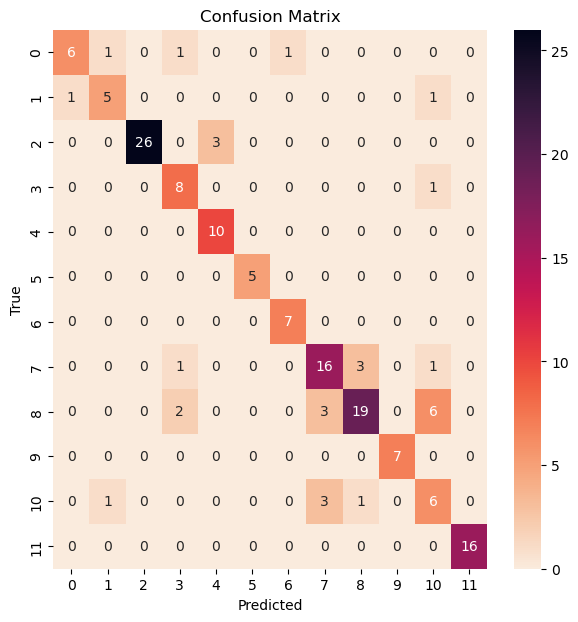

Model_04 Accuracy : 81.366460 % || Model_04 Recall : 0.842257 || Model_04 Precision : 0.819640


In [302]:
model_04 = read_model(Second_Net, "models/100epoch_5fold_2conv_focal_model04.pt") 
#  100epoch_5fold_2conv_normalized_weighted_model08.pt  

conf_mat_04, predictions_04, targets_04 = plot_confusion_matrix(model_04, test_dataset)
accuracy_04 = calc_accuracy(predictions_04, targets_04)
recall_04 = calc_recall(conf_mat_04)
predictions_04 = calc_precision(conf_mat_04)

print("Model_04 Accuracy : %f %% || Model_04 Recall : %f || Model_04 Precision : %f"%(accuracy_04, recall_04, predictions_04))

# Hyperparameter Tuning

Based on the classfication results obtained so far, the model with the best performance had the following network and training features:
- Network with 2 Conv layers + 1 FC layer, ReLU activation, Max pooling and 0.25 dropout.
- 5 fold cross validation training
- Adam optimizer with learning rate 0.003
- Class weighted `FocalLoss` function
- Data augmentation  - random horizontal and vertical flips and rotations

Now taking this model, I have further optimized its performance by tuning its hyperparameters.

In [15]:
# !pip install skorch

import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

class BestNet(nn.Module):
  def __init__(self, dropout_rate=0.25):
    super(BestNet,self). __init__()
    C_in,H_in,W_in=(3, 100, 100)
    init_f= 8
    num_fc1=100
    num_classes=12
    self.dropout_rate = dropout_rate

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
    h,w=findConv2dOutShape(H_in,W_in,self.conv1)
    
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
    h,w=findConv2dOutShape(h,w,self.conv2)

    # compute the flatten size
    self.num_flatten=h*w*2*init_f
    self.fc2 = nn.Linear(self.num_flatten, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x=F.dropout(x, self.dropout_rate)
    x = self.fc2(x)
    return x

device = torch.device("cuda")

In [16]:
params_model = {
    "input_shape" : (3, 100, 100),
    "initial_filters" : 8,
    "num_fc1" : 100,
    "num_classes" : 12,
}

skorch_model = NeuralNetClassifier(
    module = BestNet,
    criterion = FocalLoss, 
    optimizer = optim.Adam,
    max_epochs = 50,
    batch_size = 32
    
)

param_grid = {
    'optimizer__lr' : np.random.uniform(1e-5, 1e-3, size=10),
    'module__dropout_rate' : [0.25, 0.5, 0.75, 0.9],
}

grid = GridSearchCV(estimator=skorch_model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=5)
grid_result = grid.fit(train_data['images'], train_data['labels'].type(torch.LongTensor))

Fitting 2 folds for each of 40 candidates, totalling 80 fits
height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6139       0.4281        1.1948  1.9377
      2        0.9692       0.4555        0.9902  1.9587
      3        0.8050       0.4726        0.9150  1.9252
      4        0.6892       0.5000        0.8454  1.8787
      5        0.6090       0.4966        0.8199  1.8848
      6        0.5476       0.4863        0.7833  1.9257
      7        0.4956       0.5308        0.7635  2.0152
      8        0.4419       0.5240        0.7263  2.0411
      9        0.3996       0.5308        0.7075  1.9367
     10        0.3533       0.5342        0.6880  1.9732
     11        0.3138       0.5445        0.7081  1.9717
     12        0.2784       0.5582        0.6816  1.9997
     13        0.2556       0.5548        0.6883  1.9417
     14     

In [21]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.550137 using {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0007231212485077365}
0.537775 (0.000687) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0004228517846555483}
0.550137 (0.015797) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0007231212485077365}
0.354396 (0.045330) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 1.011323106917144e-05}
0.532967 (0.010989) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0003093092469055214}
0.515110 (0.001374) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0001552883319089419}
0.497940 (0.013049) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.00010141520882110982}
0.522665 (0.011676) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.00019439760926389418}
0.528846 (0.006868) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0003521051197726173}
0.530220 (0.013736) with: {'module__dropout_rate': 0.25, 'optimizer__lr': 0.0004027997994883633}
0.524725 (0.010989) with: {'modul

In [24]:
# # %%script false --no-raise-error
params_model = {
    "input_shape" : (3, 100, 100),
    "initial_filters" : 8,
    "num_fc1" : 100,
    "dropout_rate" : 0.25,
    "num_classes" : 12,
}

lr = 0.0007
batch_size = 32
model_save_name = "best_model_tuned.pt"
fold_loss, fold_acc, loss_hist, acc_hist = kfold_train(params_model, lr, batch_size, model_save_name)

FOLD 0
--------------------------------
height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
Valid Loss: 2.2767176301511998 Accuracy: 0.07534246575342465 Epoch:0
Loss: 1.8756541669163918 Accuracy: 0.27491408934707906 Epoch:0
Valid Loss: 0.8019615624048938 Accuracy: 0.5582191780821918 Epoch:20
Loss: 0.7526734906578392 Accuracy: 0.5670103092783505 Epoch:20
Valid Loss: 0.6790117531606595 Accuracy: 0.589041095890411 Epoch:40
Loss: 0.5516298945826763 Accuracy: 0.6408934707903781 Epoch:40
Valid Loss: 0.6069467226936393 Accuracy: 0.6232876712328768 Epoch:60
Loss: 0.4763015068273774 Accuracy: 0.6752577319587629 Epoch:60
Valid Loss: 0.5790209770202637 Accuracy: 0.6335616438356164 Epoch:80
Loss: 0.3747598865802345 Accuracy: 0.7207903780068728 Epoch:80
FOLD 1
--------------------------------
height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5
Valid Loss: 2.281343000451314 Accuracy: 0.09621993127147767 Epoch:0
Loss: 1.8684828119728187 Accuracy: 0.262660944206

height out:  49.0 Width out :  49.0
height out:  23.5 Width out :  23.5


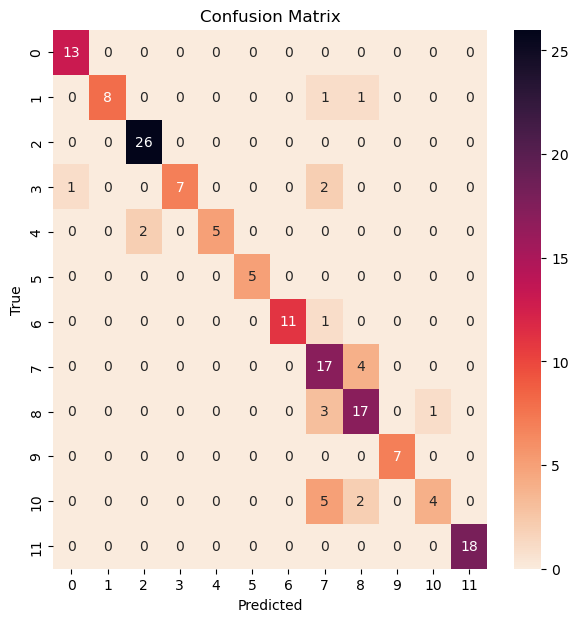

Model_best Accuracy : 85.714286 % || Model_best Recall : 0.842803 || Model_best Precision : 0.912640


In [121]:
best_model = read_model(Second_Net, "models/best_param_tuned_model.pt") 
#  100epoch_5fold_2conv_normalized_weighted_model08.pt  

conf_mat_best, predictions_best, targets_best = plot_confusion_matrix(best_model, test_dataset)
accuracy_best = calc_accuracy(predictions_best, targets_best)
recall_best = calc_recall(conf_mat_best)
predictions_best = calc_precision(conf_mat_best)

print("Model_best Accuracy : %f %% || Model_best Recall : %f || Model_best Precision : %f"%(accuracy_best, recall_best, predictions_best))